# Загрузка зависимостей

In [14]:
!nvidia-smi

Sat Sep 13 20:10:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.77                 Driver Version: 565.77         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1050        Off |   00000000:03:00.0 Off |                  N/A |
| 37%   28C    P8             N/A /   75W |      10MiB /   2048MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Всё, что нужно устанавливается через uv

In [1]:
!uv sync
!cd ManiSkill && uv pip install -e . && cd ..
!cd SimplerEnv && uv pip install -e . && cd ..

Resolved 109 packages in 0.51ms
Uninstalled 34 packages in 59ms
Installed 1 package in 16ms                                 
 - absl-py==2.3.1
 - arm-pytorch-utilities==0.4.3
 - cloudpickle==3.1.1
 - dacite==1.9.2
 - docstring-parser==0.17.0
 - farama-notifications==0.0.4
 - fast-kinematics==0.2.2
 - gitdb==4.0.12
 - gitpython==3.1.45
 - gymnasium==0.29.1
 - h5py==3.14.0
 - imageio==2.37.0
 - imageio-ffmpeg==0.6.0
 - lxml==6.0.1
 - mani-skill==3.0.0b20 (from file:///home/jezv/Projects/RL4VLA/ManiSkill)
 - mplib==0.1.1
 - numpy==1.26.4
 + numpy==2.2.6
 - nvidia-ml-py==13.580.82
 - opencv-python==4.11.0.86
 - pynvml==13.0.1
 - pyperclip==1.9.0
 - pytorch-kinematics==0.7.5
 - pytorch-seed==0.2.0
 - sapien==3.0.0b1
 - scipy==1.15.3
 - shtab==1.7.2
 - simpler-env==0.0.1 (from file:///home/jezv/Projects/RL4VLA/SimplerEnv)
 - smmap==5.0.2
 - tabulate==0.9.0
 - toppra==0.6.3
 - transforms3d==0.4.2
 - trimesh==4.8.1
 - typeguard==4.4.4
 - tyro==0.9.31
Using Python 3.10.12 environment at: /home/

Нужно в моём случае, потому что у меня первая видеокарта - 1050ti, которая не умеет работать с CUDA

In [2]:
!export CUDA_VISIBLE_DEVICES=1

In [3]:
import comet_ml

comet_ml.login(project_name="AIRI_Task")

# Collecting a datasets
for Requried step 3

## Collect base dataset

In [43]:
import gymnasium as gym
from mani_skill.envs import *

task = 'PutOnPlateInScene25MultiCarrot-v1'
env = gym.make(task, 
               num_envs=1,
               obs_mode='rgb+segmentation')
question = 'What objects are in the scene?'

xyz_configs: (2104, 3, 3)
quat_configs: (4, 2, 4)


In [44]:
from tqdm import tqdm
from pathlib import Path
from PIL import Image

experiment_config = comet_ml.ExperimentConfig(
    name="Collecting objects dataset",
)
experiment = comet_ml.start(project='AIRI_Task', experiment_config=experiment_config)
comet_dataset = comet_ml.Artifact(name="BaseDataset", artifact_type="dataset")

start_seed = 42 
corrects = []
images_path = Path('./images')
images_path.mkdir(exist_ok=True)
dataset_path = Path('./base_data.csv')
if (dataset_path.exists() and \
    input(f"{dataset_path} already exsits, you want to owerwrite it? [Y/n]") == 'Y') or \
    not dataset_path.exists():
    with open(dataset_path, 'w') as f: f.write('question,image_path,answer\n')

for i in tqdm(range(250)):
    obs, reset_info = env.reset(seed = start_seed + i)
    image = Image.fromarray(obs['sensor_data']['3rd_view_camera']['rgb'].detach().cpu().numpy()[0])
    image_path = images_path / f'image{i}.png'
    image.save(image_path)

    action_carrot = env.unwrapped.carrot_names[env.unwrapped.select_carrot_ids[0]].split('_')[1]
    extra_carrot = env.unwrapped.carrot_names[env.unwrapped.select_extra_ids[0]].split('_')[1]
    plate = env.unwrapped.plate_names[env.unwrapped.select_plate_ids[0]].split('_')[1]
    answer = ','.join([action_carrot, extra_carrot, plate]).capitalize()

    data_row = ','.join([question, str(image_path), f'"{answer}"']) + '\n'
    with open(dataset_path, '+a') as f:
        f.write(data_row)
    
comet_dataset.add(images_path)
comet_dataset.add(dataset_path)

experiment.log_artifact(comet_dataset)

experiment.end()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/jezvgg/airi-task/9e2465499b2b413e88713b3ff6ae11b7

100%|██████████| 250/250 [00:48<00:00,  5.13it/s]
COMET INFO: Artifact 'BaseDataset' version 6.0.0 created (previous was: 5.0.0)
COMET INFO: Scheduling the upload of 251 assets: 251 local assets for a size of 73.12 MB, and 0 remote assets (will be linked, not uploaded). This can take some time.
COMET INFO: Artifact 'jezvgg/BaseDataset:6.0.0' has started uploading asynchronously
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name       

## Collect extended dataset

In [4]:
import gymnasium as gym
from mani_skill.envs import *

task = 'PutOnPlateInScene25MultiCarrot-v1'
envs = [gym.make(task, 
        num_envs=1,
        obs_mode='rgb+segmentation') for task in ['PutOnPlateInScene25Main-v3', 'PutOnPlateInScene25MultiCarrot-v1']]

task_questions = [
    'What objects do you see?',
    'What color or material is the table?',
    'What is on the table?',
    'What can you eat on the table?',
    'What is closest to the edge of the table?',
    'What is most likely to fall off a table?'
]

/home/jezv/Projects/RL4VLA/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/home/jezv/Projects/RL4VLA/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jezv/Projects/RL4VLA/.venv/lib/python3.10/site-packages/sapien/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/home/jezv/Projects/RL4VLA/.venv/lib/python3.

xyz_configs: (2104, 3, 3)
quat_configs: (4, 2, 4)


Generative answers

In [5]:
from mani_skill.envs.sapien_env import BaseEnv

table_materials = [
    'wood',
    'plastic',
    'black',
    'gray',
    'wood',
    'wood',
    'yellow',
    'granite',
    'gray',
    'white',
    'granite',
    'pink',
    'wood',
    'grass',
    'wood',
    'colorful',
    'glass',
    'green',
    'pink',
    'stone',
    'wood'
]

eatable = ['001_carrot_simpler', '003_bread_1', '005_7up can_1', '006_zuchinni_1', '007_ketchup bottle_1', '008_watering can_1', '011_fast food cup_1', '013_banana_1', '014_hamburger_1', '016_BBQ sauce_1', '018_pepper_1', '020_potato_1', '021_baguette_1', '022_champagne glass_1', '024_onion_1']
eatable = set([obj.split('_')[1] for obj in eatable])

table_open_sides = [
    [2],
    [1,2],
    [1,2],
    [0,1,2],
    [1,2],
    [0,1,2],
    [0,1,2],
    [0,1,2],
    [1,2],
    [2],
    [0,1,2],
    [1,2],
    [0,1,2],
    [0,1,2],
    [0,1,2],
    [2],
    [0,1,2],
    [0,1,2],
    [2],
    [0,1,2],
    [0,1,2]
]


def get_objects(env: BaseEnv) -> list:
    objects = []
    objects.append(env.unwrapped.carrot_names[env.unwrapped.select_carrot_ids[0]].split('_')[1])
    objects.append(env.unwrapped.plate_names[env.unwrapped.select_plate_ids[0]].split('_')[1])
    if hasattr(env.unwrapped, 'select_extra_ids'):
        objects.append(env.unwrapped.carrot_names[env.unwrapped.select_extra_ids[0]].split('_')[1])
    return objects


def get_objects_all(env: BaseEnv) -> list:
    objects = get_objects(env)
    objects += ['manipulator', 'table']
    return objects


def get_table_material(env: BaseEnv) -> list:
    material = table_materials[env.unwrapped.select_overlay_ids[0]]
    return [material]


def get_eatable(env: BaseEnv) -> list:
    objects = get_objects(env)
    eatable_objects = set(objects) & eatable
    return list(eatable_objects)


def get_edge_distance(object: tuple[int, int]) -> tuple[int, int, int]:
    object = np.array(object) * np.array([640, 480])
    dotI = np.array([160, 71])
    dotII = np.array([69, 215])
    dotIII = np.array([0, 179])
    dotIV = np.array([0, 318])
    dotV = np.array([310,479])

    s1 = dotI - dotII
    edge1_distance = np.abs((np.cross(object, dotI) * s1)) / np.abs(s1)

    s2 = dotI - dotIII
    edge2_distance = np.abs((np.cross(object, dotI) * s2)) / np.abs(s2)

    s3 = dotIV - dotV
    edge3_distance = np.abs((np.cross(object, dotV) * s3)) / np.abs(s3)

    return edge1_distance, edge2_distance, edge3_distance


def get_closest_to_edge(env: BaseEnv) -> list:
    distances = {}
    objects_position = env.unwrapped.xyz_configs[env.unwrapped.select_pos_ids][:, :2]

    carrot_object_name = env.unwrapped.carrot_names[env.unwrapped.select_carrot_ids[0]].split('_')[1]
    carrot_distance = np.min(get_edge_distance(objects_position[0]))
    distances[carrot_distance] = carrot_object_name

    plate_object_name = env.unwrapped.plate_names[env.unwrapped.select_plate_ids[0]].split('_')[1]
    plate_distance = np.min(get_edge_distance(objects_position[1]))
    distances[plate_distance] = plate_object_name

    if hasattr(env.unwrapped, 'select_extra_ids'):
        extra_object_name = env.unwrapped.carrot_names[env.unwrapped.select_extra_ids[0]].split('_')[1]
        extra_distance = np.min(get_edge_distance(objects_position[2]))
        distances[extra_distance] = extra_object_name

    return [distances[min(distances.keys())]]


def get_fall_objects(env: BaseEnv) -> list:
    distances = {}
    objects_position = env.unwrapped.xyz_configs[env.unwrapped.select_pos_ids][:, :2]
    sides = table_open_sides[env.unwrapped.select_overlay_ids[0]]

    carrot_object_name = env.unwrapped.carrot_names[env.unwrapped.select_carrot_ids[0]].split('_')[1]
    carrot_distance = np.array(get_edge_distance(objects_position[0]))[sides].min()
    distances[carrot_distance] = carrot_object_name

    plate_object_name = env.unwrapped.plate_names[env.unwrapped.select_plate_ids[0]].split('_')[1]
    plate_distance = np.array(get_edge_distance(objects_position[1]))[sides].min()
    distances[plate_distance] = plate_object_name

    if hasattr(env.unwrapped, 'select_extra_ids'):
        extra_object_name = env.unwrapped.carrot_names[env.unwrapped.select_extra_ids[0]].split('_')[1]
        extra_distance = np.array(get_edge_distance(objects_position[2]))[sides].min()
        distances[extra_distance] = extra_object_name

    return [distances[min(distances.keys())]]

task_answers = [
    get_objects_all,
    get_table_material,
    get_objects,
    get_eatable,
    get_closest_to_edge,
    get_fall_objects
]

In [7]:
from tqdm import tqdm
from pathlib import Path
from PIL import Image

experiment_config = comet_ml.ExperimentConfig(
    name="Collecting extended dataset",
)
experiment = comet_ml.start(project='AIRI_Task', experiment_config=experiment_config)
comet_dataset = comet_ml.Artifact(name="ExtendedDataset", artifact_type="dataset")

start_seed = 42 
corrects = []
images_path = Path('./images')
images_path.mkdir(exist_ok=True)
dataset_path = Path('./extended_data.csv')
if (dataset_path.exists() and \
    input(f"{dataset_path} already exsits, you want to owerwrite it? [Y/n]") == 'Y') or \
    not dataset_path.exists():
    with open(dataset_path, 'w') as f: 
        dataset_head = ','.join([f"question{i},answer{i}" for i in range(len(task_questions))]) + ',image_path\n'
        f.write(dataset_head)


for i in tqdm(range(250)):
    for env in envs:
        obs, reset_info = env.reset(seed = start_seed + i)
        image = Image.fromarray(obs['sensor_data']['3rd_view_camera']['rgb'].detach().cpu().numpy()[0])
        image_path = images_path / f'image{i}.png'
        image.save(image_path)

        QA = [question+','+f"\"{(';'.join(answer_function(env)) or 'nothing').capitalize()}\"" \
                for question, answer_function in zip(task_questions, task_answers)]
        # print(QA)
        data_row = ','.join(QA) + ',' + str(image_path) + '\n'
        with open(dataset_path, '+a') as f:
            f.write(data_row)
    
comet_dataset.add(images_path)
comet_dataset.add(dataset_path)

experiment.log_artifact(comet_dataset)

experiment.end()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/jezvgg/airi-task/d81caf8e278d49008041720ec9a80563

100%|██████████| 250/250 [01:38<00:00,  2.54it/s]
COMET INFO: Artifact 'ExtendedDataset' version 9.0.0 created (previous was: 8.0.0)
COMET INFO: Scheduling the upload of 251 assets: 251 local assets for a size of 73.26 MB, and 0 remote assets (will be linked, not uploaded). This can take some time.
COMET INFO: Artifact 'jezvgg/ExtendedDataset:9.0.0' has started uploading asynchronously
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     nam

# Zero-shot evaluation
Required Step 1 and 2

## Base dataset evaluation
Required Step 2

In [4]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-Instruct")
model = AutoModelForImageTextToText.from_pretrained(
    "HuggingFaceTB/SmolVLM-Instruct",
    torch_dtype=torch.bfloat16
).to(DEVICE)

/home/jezv/Projects/RL4VLA/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/home/jezv/Projects/RL4VLA/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 2 files: 100%|██████████| 2/2 [00:00<00:00, 43690.67it/s]
`torch_dtype` is deprecated! Use `dtype` instead!
/home/jezv/Projects/RL4VLA/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:283: UserWarning: 
    Found GPU1 NVIDIA GeForce GTX 1050 which is of cuda capability 6.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (7.0) - (12.0)
  

In [13]:
from tqdm import tqdm
from collections import defaultdict
from pathlib import Path
import pandas as pd
from PIL import Image


experiment_config = comet_ml.ExperimentConfig(
    name="Base dataset evaluating",
)
experiment = comet_ml.start(project='AIRI_Task', experiment_config=experiment_config)
experiment.add_tag('eval')
dataset_path = Path('./dataset')
if not dataset_path.exists():
    dataset_path.mkdir()
    artefact = experiment.get_artifact('BaseDataset') # latest
    artefact.download(dataset_path, overwrite_strategy="PRESERVE")
dataset = pd.read_csv(dataset_path / 'base_data.csv')
dataset.reset_index()


start_seed = 42 # Объявим начальный сид, чтоб потом детерменированно создавать среды для наилучшего воспроизведения
corrects = []
objects_stats = defaultdict(int)


for i in tqdm(range(dataset.shape[0])):
    image_path = dataset_path / dataset['image_path'][i]
    image = Image.open(image_path)
    messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", 'text': dataset['question'][i]}
                ]
            }
        ]
    
    prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(text=prompt, images=[image], return_tensors="pt")
    inputs = inputs.to(DEVICE)
        
    generated_ids = model.generate(**inputs, max_new_tokens=500)
    generated_texts: list[str] = processor.batch_decode(
        generated_ids,
        skip_special_tokens=True,
    )

    keywords: list[str] = dataset['answer'][i].split(',')
    correct = True
    for keyword in keywords:
        done = keyword.lower() in generated_texts[0].split('\n')[-1].lower()
        if not done: objects_stats[keyword] += 1
        correct &= done
    corrects.append(correct)

    experiment.log_metric("success_rate", (sum(corrects) / len(corrects))*100, step=i)
    experiment.log_others(objects_stats)

print(f"SR: {(sum(corrects) / len(corrects))*100:.2f}%")

experiment.end()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/jezvgg/airi-task/1748aac214a24259b982e261f2422c65

100%|██████████| 250/250 [04:35<00:00,  1.10s/it]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Base dataset evaluating
COMET INFO:     url                   : https://www.comet.com/jezvgg/airi-task/1748aac214a24259b982e261f2422c65
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     success_rate [250] : (0.0, 11.11111111111111)
COMET INFO:   Others:
COMET INFO:     7up can        : 22
COMET INFO:     Bana

SR: 3.60%


COMET INFO: Uploading 6482 metrics, params and output messages
COMET INFO: Uploading 6428 metrics, params and output messages
COMET INFO: Uploading 6378 metrics, params and output messages
COMET INFO: Uploading 6325 metrics, params and output messages
COMET INFO: Uploading 6271 metrics, params and output messages
COMET INFO: Uploading 6216 metrics, params and output messages
COMET INFO: Uploading 6163 metrics, params and output messages
COMET INFO: Uploading 6108 metrics, params and output messages
COMET INFO: Uploading 6054 metrics, params and output messages
COMET INFO: Uploading 6001 metrics, params and output messages
COMET INFO: Uploading 5947 metrics, params and output messages
COMET INFO: Uploading 5893 metrics, params and output messages
COMET INFO: Uploading 5841 metrics, params and output messages
COMET INFO: Uploading 5787 metrics, params and output messages
COMET INFO: Uploading 5733 metrics, params and output messages
COMET INFO: Uploading 5679 metrics, params and output m

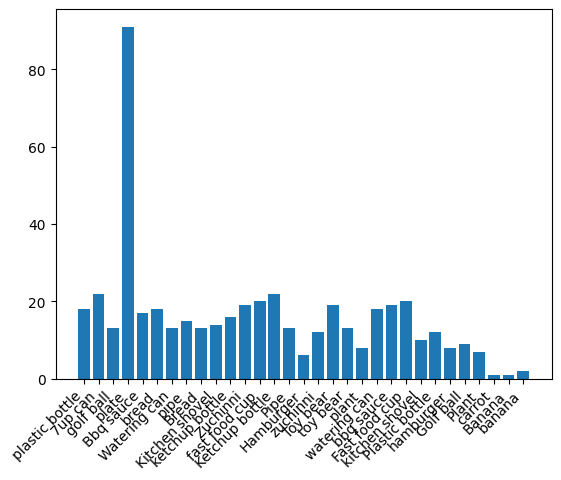

In [14]:
import matplotlib.pyplot as plt

plt.xticks(rotation=45, ha='right')
plt.bar(objects_stats.keys(), objects_stats.values());

## Extended dataset evaluation
Requried Step 1

In [8]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-Instruct")
model = AutoModelForImageTextToText.from_pretrained(
    "HuggingFaceTB/SmolVLM-Instruct",
    torch_dtype=torch.bfloat16
).to(DEVICE)

Fetching 2 files: 100%|██████████| 2/2 [00:00<00:00, 41323.19it/s]
`torch_dtype` is deprecated! Use `dtype` instead!


In [ ]:
from tqdm import tqdm
from collections import defaultdict
from pathlib import Path
import pandas as pd
from PIL import Image


experiment_config = comet_ml.ExperimentConfig(
    name="Extended dataset evaluating",
)
experiment = comet_ml.start(project='AIRI_Task', experiment_config=experiment_config)
experiment.add_tag('eval')
dataset_path = Path('./dataset')
if not dataset_path.exists():
    dataset_path.mkdir()
    artefact = experiment.get_artifact('ExtendedDataset') # latest
    artefact.download(dataset_path, overwrite_strategy="PRESERVE")
dataset = pd.read_csv(dataset_path / 'extended_data.csv', engine='python', quotechar='"', doublequote=True)
dataset.reset_index()


start_seed = 42 # Объявим начальный сид, чтоб потом детерменированно создавать среды для наилучшего воспроизведения
corrects = []
objects_stats = defaultdict(lambda: defaultdict(int))


for i in tqdm(range(dataset.shape[0])):
    image_path = dataset_path / dataset['image_path'][i]
    image = Image.open(image_path)
    for j in range(dataset.shape[1] // 2):
        messages = [
                {
                    "role": "user",
                    "content": [
                        {"type": "image"},
                        {"type": "text", 'text': dataset[f'question{j}'][i]}
                    ]
                }
            ]
        
        prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
        inputs = processor(text=prompt, images=[image], return_tensors="pt")
        inputs = inputs.to(DEVICE)
            
        generated_ids = model.generate(**inputs, max_new_tokens=500)
        generated_texts: list[str] = processor.batch_decode(
            generated_ids,
            skip_special_tokens=True,
        )

        keywords: list[str] = dataset[f'answer{j}'][i].split(';')
        correct = True
        for keyword in keywords:
            done = keyword.lower() in generated_texts[0].split('\n')[-1].lower()
            if not done: objects_stats[dataset[f'question{j}'][i]][keyword] += 1
            correct &= done
        corrects.append(correct)

    experiment.log_metric("success_rate", (sum(corrects) / len(corrects))*100, step=i)
    experiment.log_others(objects_stats)

print(f"SR: {(sum(corrects) / len(corrects))*100:.2f}%")

experiment.end()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/jezvgg/airi-task/d849ce02404a4f84a7e06b7ddf921c13

100%|██████████| 500/500 [35:12<00:00,  4.23s/it]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Extendeddataset evaluating
COMET INFO:     url                   : https://www.comet.com/jezvgg/airi-task/d849ce02404a4f84a7e06b7ddf921c13
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     success_rate [500] : (6.862745098039216, 25.0)
COMET INFO:   Others:
COMET INFO:     Name                                

SR: 11.17%


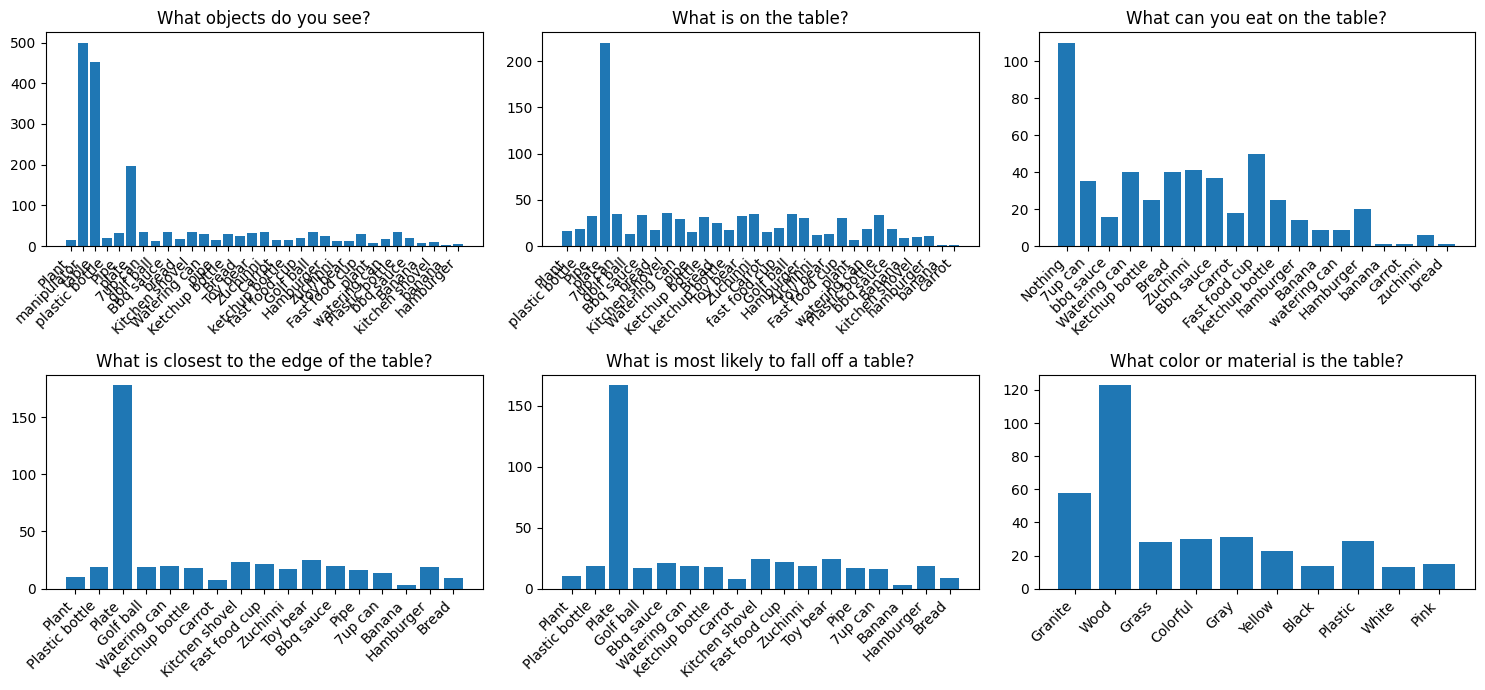

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))

for i in range(2):
    for j in range(3):
        plt.subplot(2, 3, i*3+(j+1))
        question = list(objects_stats.keys())[i*3+j]
        plt.title(question)
        plt.xticks(rotation=45, ha='right')
        if not list(objects_stats[question].values()): continue
        plt.bar(objects_stats[question].keys(), objects_stats[question].values())
plt.tight_layout()
plt.show();

# Supervised fine-tuning VLM
Reuired step 3

## SFT on Base dataset

# Required Step 1

In [6]:
# Задачи, на которых будем тестировать модель
tasks = ['PutCarrotOnPlateInScene-v1', 'PutOnPlateInScene25MultiCarrot-v1']

/home/jezv/Projects/RL4VLA/.venv/lib/python3.10/site-packages/torch/random.py:187: UserWarning: CUDA reports that you have 2 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of CUDAs. If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using. For example, if you are using CPU only, set device.upper()_VISIBLE_DEVICES= or devices=[]; if you are using device 0 only, set CUDA_VISIBLE_DEVICES=0 or devices=[0].  To initialize all devices and suppress this warning, set the 'devices' keyword argument to `range(torch.cuda.device_count())`.
  warnings.warn(message)
/home/jezv/Projects/RL4VLA/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:283: UserWarning: 
    Found GPU1 NVIDIA GeForc

xyz_configs: (2104, 3, 3)
quat_configs: (4, 2, 4)


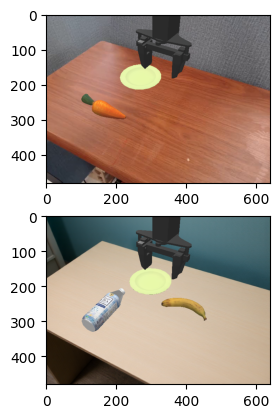

In [7]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

task_images = []

for i,task in enumerate(tasks):
    env = gym.make(task, 
               num_envs=1,
               obs_mode='rgb+segmentation')
    
    obs, reset_info = env.reset(seed = 42)
    task_images.append(obs['sensor_data']['3rd_view_camera']['rgb'].detach().cpu().numpy()[0])
    plt.subplot(len(tasks), 1, i+1)
    plt.imshow(task_images[-1])


task_images = np.array(task_images)
plt.show()

In [ ]:
task_questions = [
    'What objects do you see?',
    'What is the table made of?',
    'What is on the table?',
    'What can you eat on the table?',
    'What is closest to the edge of the table?',
    'What is most likely to fall off a table?'
]
task_answers = [
    ['I see a table, a plate, a carrot and a manipuletor.', 'I see a table, a plate, a banana, a bottle and a manipuletor.'],
    ['wood', 'Table made of something beige.'],
    ['There is a carrot and a plate on the table.', 'There is a banana, a bottle and a plate on the table'],
    ['I can eat a carrot.', 'I can eat a banana.'],
    ['A carrot', 'A bottle'],
    ['A carrot', 'A bottle']
]

In [7]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText
from bert_score import score

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-Instruct")
model = AutoModelForImageTextToText.from_pretrained(
    "HuggingFaceTB/SmolVLM-Instruct",
    torch_dtype=torch.bfloat16
).to(DEVICE)

Fetching 2 files: 100%|██████████| 2/2 [00:00<00:00, 27324.46it/s]
`torch_dtype` is deprecated! Use `dtype` instead!


## Рассчёт SR при помощи BertScore

In [9]:
for question, answer in zip(task_questions, task_answers):
    for i,image in enumerate(task_images):
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", 'text': question}
                ]
            },
        ]

        prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
        inputs = processor(text=prompt, images=[image], return_tensors="pt")
        inputs = inputs.to(DEVICE)
        
        generated_ids = model.generate(**inputs, max_new_tokens=500)
        generated_texts = processor.batch_decode(
            generated_ids,
            skip_special_tokens=True,
        )

        print(generated_texts[0])
        print(answer[i])
        results = score(generated_texts, [answer[i]], lang='en')
        print(results)


User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What objects do you see?
Assistant: Carrot and plate.
I see a table, a plate, a carrot and a manipuletor.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.7479]), tensor([0.8471]), tensor([0.7944]))
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What objects do you see?
Assistant: Bottle, plate, banana, and a microscope.
I see a table, a plate, a banana, a bottle and a manipuletor.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.7475]), tensor([0.8969]), tensor([0.8154]))
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What is the table made of?
Assistant: Wood.
Table made of wood.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.7079]), tensor([0.9137]), tensor([0.7977]))
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What is the table made of?
Assistant: Wood.
Table made of something beige.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.7108]), tensor([0.8661]), tensor([0.7808]))
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What is on the table?
Assistant: Carrot and plate.
There is a carrot and a plate on the table.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.7289]), tensor([0.9019]), tensor([0.8062]))
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What is on the table?
Assistant: Bottle, plate, and bananas
There is a banana, a bottle and a plate on the table


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.7361]), tensor([0.9016]), tensor([0.8105]))
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What can you eat on the table?
Assistant: Carrot.
I can eat a carrot.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.7149]), tensor([0.9009]), tensor([0.7972]))
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What can you eat on the table?
Assistant: Banana.
I can eat a banana.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.7141]), tensor([0.8979]), tensor([0.7955]))
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What is closest to the edge of the table?
Assistant: Carrot.
A carrot


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.6938]), tensor([0.8814]), tensor([0.7764]))
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What is closest to the edge of the table?
Assistant: Bottle.
A bootle


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.6935]), tensor([0.8148]), tensor([0.7493]))
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What is most likely to fall off a table?
Assistant: Carrot.
A carrot


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.6911]), tensor([0.8765]), tensor([0.7728]))
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What is most likely to fall off a table?
Assistant: Banana.
A bootle


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(tensor([0.6887]), tensor([0.8022]), tensor([0.7412]))


## Рассчёт SR при помощи SelfCheck

In [ ]:
for question, answer in zip(task_questions, task_answers):
    for i,image in enumerate(task_images):
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", 'text': question}
                ]
            },
        ]

        prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
        inputs = processor(text=prompt, images=[image], return_tensors="pt")
        inputs = inputs.to(DEVICE)
        
        generated_ids = model.generate(**inputs, max_new_tokens=500)
        generated_texts = processor.batch_decode(
            generated_ids,
            skip_special_tokens=True,
        )
        print(generated_texts[0].split('\n')[-1])
        print(answer[i])

        messages += [
            {
                "role": "assistant",
                "content": [
                    {"type": "text", 'text': generated_texts[0]}
                ]
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", 'text': f"Right answer was: {answer[i]}. Do you think you answered correctly? Your answer does not have to match exactly, but semantically. Answer: [Yes/No]"}
                ]
            },
        ]

        prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
        inputs = processor(text=prompt, images=[image], return_tensors="pt")
        inputs = inputs.to(DEVICE)
        
        generated_ids = model.generate(**inputs, max_new_tokens=500)
        generated_texts = processor.batch_decode(
            generated_ids,
            skip_special_tokens=True,
        )

        print(generated_texts[0])
        print(generated_texts[0].split('\n')[-1])

Assistant: Carrot and plate.
I see a table, a plate, a carrot and a manipuletor.
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What objects do you see?
Assistant: User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><row_3_col_3><row_3_col_4>

<global-img>What objects do you see?
Assistant: Carrot and plate.
User: Right answer was: I see a table, a plate, a carrot and a manipuletor..Do you think you answered correctly? Your answer does not have to match exactly, but semantically. Answer: [Yes/No]
Assistant: No.
Assistant: No.
Assistant: Bottle, plate, banana, and a microscope.
I see a table, a plate, a banana, a bottle and a manipuletor.
User:<row_1_col_1><row_1_col_2><row_1_col_3><row_1_col_4>
<row_2_col_1><row_2_col_2><row_2_col_3><row_2_col_4>
<row_3_col_1><row_3_col_2><r

## Рассчёт SR при помощи ключевых слов

In [13]:
task_questions = [
    'What objects do you see?',
    'What is the table made of?',
    'What is on the table?',
    'What can you eat on the table?',
    'What is closest to the edge of the table?',
    'What is most likely to fall off a table?'
]
task_answers = [
    [('table', 'plate', 'carrot', 'manipulator'), ('table', 'plate', 'banana', 'bottle', 'manipulator')],
    [('wood'), ('wood')],
    [('carrot', 'plate'), ('banana', 'bottle', 'plate')],
    [('carrot'), ('banana')],
    [('carrot'), ('bottle')],
    [('carrot'), ('bottle')]
]

In [17]:
corrects = 0

for question, answer in zip(task_questions, task_answers):
    for i,image in enumerate(task_images):
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", 'text': question}
                ]
            },
        ]

        prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
        inputs = processor(text=prompt, images=[image], return_tensors="pt")
        inputs = inputs.to(DEVICE)
        
        generated_ids = model.generate(**inputs, max_new_tokens=500)
        generated_texts = processor.batch_decode(
            generated_ids,
            skip_special_tokens=True,
        )

        correct = True
        for keyword in answer[i]:
            correct &= keyword in generated_texts[0].split('\n')[-1].lower()
        if correct: corrects += 1

        print(correct)
        print(generated_texts[0].split('\n')[-1])
        print(answer[i])

SR = corrects / (len(task_questions)*len(task_images))
print('='*30)
print(f'{SR*100:.2f}%')

False
Assistant: Carrot and plate.
('table', 'plate', 'carrot', 'manipulator')
False
Assistant: Bottle, plate, banana, and a microscope.
('table', 'plate', 'banana', 'bottle', 'manipulator')
True
Assistant: Wood.
wood
True
Assistant: Wood.
wood
True
Assistant: Carrot and plate.
('carrot', 'plate')
True
Assistant: Bottle, plate, and bananas
('banana', 'bottle', 'plate')
True
Assistant: Carrot.
carrot
True
Assistant: Banana.
banana
True
Assistant: Carrot.
carrot
True
Assistant: Bottle.
bottle
True
Assistant: Carrot.
carrot
False
Assistant: Banana.
bottle
75.00%


| Task | Model | SR |
| --- | --- | --- |
| PutCarrotOnPlateInScene-v1 | SmolVLM | 75% |
| PutOnPlateInScene25MultiCarrot-v1 | SmolVLM | 75% |